In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
df = pd.read_csv('../datasets/clean_dataset.csv')

RANDOM_SEED=42

### Algorithm selection

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve,f1_score,accuracy_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler

In [37]:
features = ['close_loans_cnt','federal_district_nm','TraderKey','payment_type_0','payment_type_1','payment_type_2','payment_type_3','payment_type_4','past_billings_cnt','score_1','age','gender','diff_loans']
target = 'bad_flag'

In [38]:
X_train,X_test,y_train,y_test = train_test_split(df[features],df[target],test_size=0.2,stratify=df[target],random_state=RANDOM_SEED)

In [39]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(random_state=RANDOM_SEED),
    BaggingClassifier(random_state=RANDOM_SEED),
    GaussianNB(),
    RandomForestClassifier(n_estimators=100,random_state=RANDOM_SEED),
    ExtraTreesClassifier(n_estimators=100,random_state=RANDOM_SEED)
]

In [40]:
def class_metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("f1 score:", f1)

    return

In [41]:
def plot_cm(cm):
    # Definir etiquetas de clase
    classes=["bad_flag=0", "bad_flag=1"]

    # Crear mapa de calor de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [42]:
def plot_roc(classifier,X_test,y_test):
    y_probs = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positives (FPR)')
    plt.ylabel('True positives (TPR)')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

## 1. Experiment 1

#### Undersampling with RandomUnderSampler()

In [43]:

ru = RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ru.fit_resample(X_train, y_train)

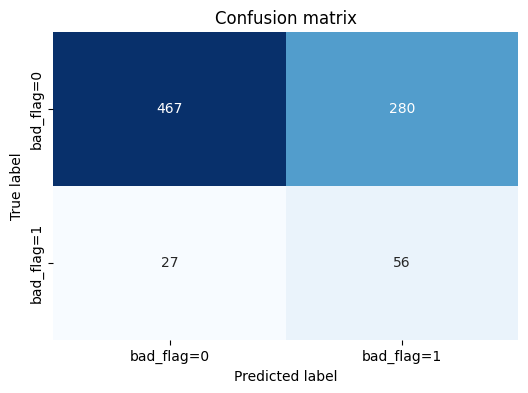

KNeighborsClassifier
Accuracy: 0.6301204819277109
Precision: 0.16666666666666666
Recall: 0.6746987951807228
f1 score: 0.26730310262529833


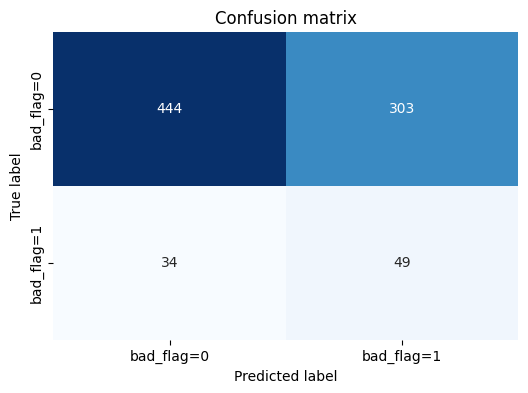

LogisticRegression
Accuracy: 0.5939759036144578
Precision: 0.13920454545454544
Recall: 0.5903614457831325
f1 score: 0.22528735632183905


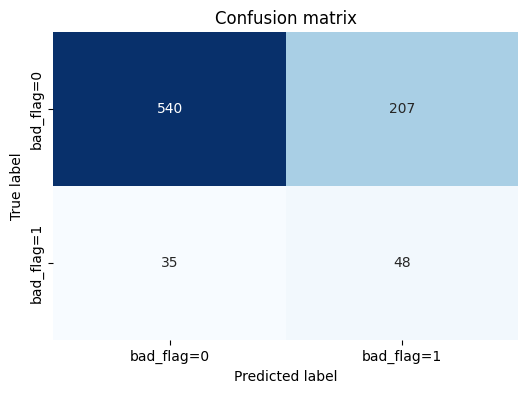

BaggingClassifier
Accuracy: 0.708433734939759
Precision: 0.18823529411764706
Recall: 0.5783132530120482
f1 score: 0.28402366863905326


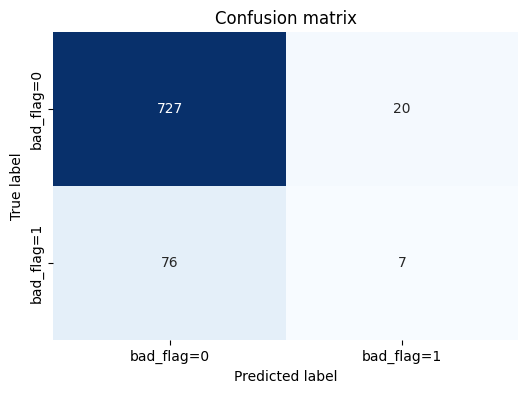

GaussianNB
Accuracy: 0.8843373493975903
Precision: 0.25925925925925924
Recall: 0.08433734939759036
f1 score: 0.1272727272727273


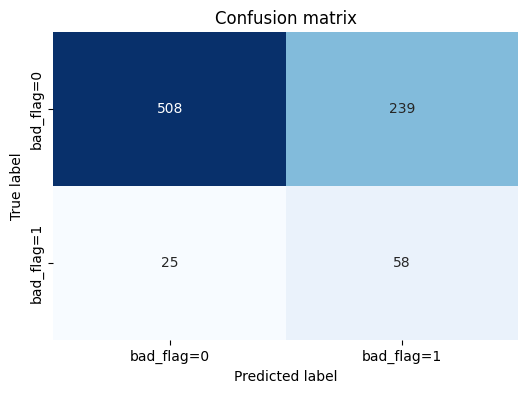

RandomForestClassifier
Accuracy: 0.6819277108433734
Precision: 0.19528619528619529
Recall: 0.6987951807228916
f1 score: 0.30526315789473685


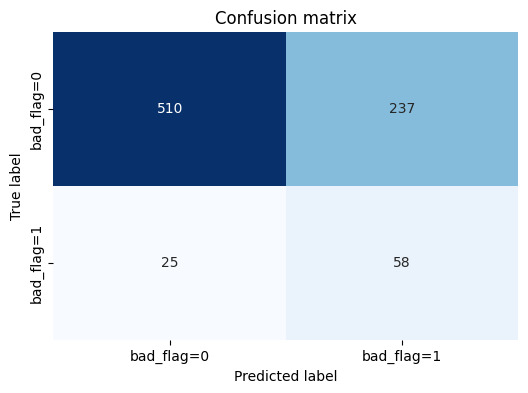

ExtraTreesClassifier
Accuracy: 0.6843373493975904
Precision: 0.19661016949152543
Recall: 0.6987951807228916
f1 score: 0.3068783068783069


In [44]:
for classifier in classifiers:
    classifier.fit(X=X_resampled, y=y_resampled)
    y_pred = classifier.predict(X=X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_cm(cm)
    
    print(classifier.__class__.__name__)
    class_metrics(y_test=y_test,y_pred=y_pred)

The best f1 score has been obtained by the RandomForest algorithm so we are going to use the hyperparameter optimization:

In [45]:
import optuna 
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score,recall_score


In [46]:
def objective(trial: optuna.Trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)



    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,

        random_state=RANDOM_SEED
    )

    classifier = clf.fit(X=X_resampled, y=y_resampled)
    y_pred = classifier.predict(X=X_test)

    return f1_score(y_true=y_test, y_pred=y_pred)

In [47]:
sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction="maximize",study_name="RandomForest",sampler=sampler)
study.optimize(objective, n_trials=20)

print("Best F1-score: ", study.best_value)
print("Best params: ", study.best_params)

[I 2023-08-08 18:45:23,610] A new study created in memory with name: RandomForest
[I 2023-08-08 18:45:23,976] Trial 0 finished with value: 0.31382978723404253 and parameters: {'n_estimators': 106, 'max_depth': 15}. Best is trial 0 with value: 0.31382978723404253.
[I 2023-08-08 18:45:24,439] Trial 1 finished with value: 0.3010204081632653 and parameters: {'n_estimators': 160, 'max_depth': 10}. Best is trial 0 with value: 0.31382978723404253.
[I 2023-08-08 18:45:24,599] Trial 2 finished with value: 0.31662269129287596 and parameters: {'n_estimators': 73, 'max_depth': 5}. Best is trial 2 with value: 0.31662269129287596.
[I 2023-08-08 18:45:24,783] Trial 3 finished with value: 0.3116883116883117 and parameters: {'n_estimators': 58, 'max_depth': 14}. Best is trial 2 with value: 0.31662269129287596.
[I 2023-08-08 18:45:25,197] Trial 4 finished with value: 0.3128205128205128 and parameters: {'n_estimators': 140, 'max_depth': 12}. Best is trial 2 with value: 0.31662269129287596.
[I 2023-08-08 

Best F1-score:  0.33066666666666666
Best params:  {'n_estimators': 164, 'max_depth': 4}


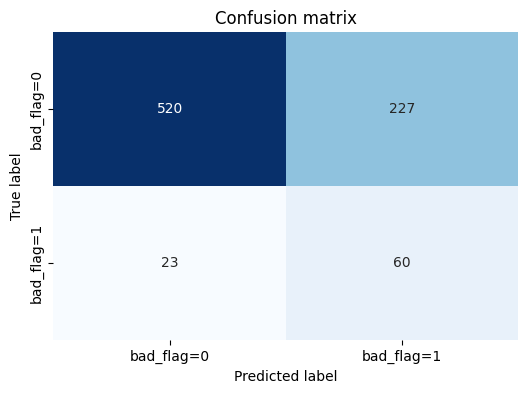

Accuracy: 0.6987951807228916
Precision: 0.20905923344947736
Recall: 0.7228915662650602
f1 score: 0.32432432432432434


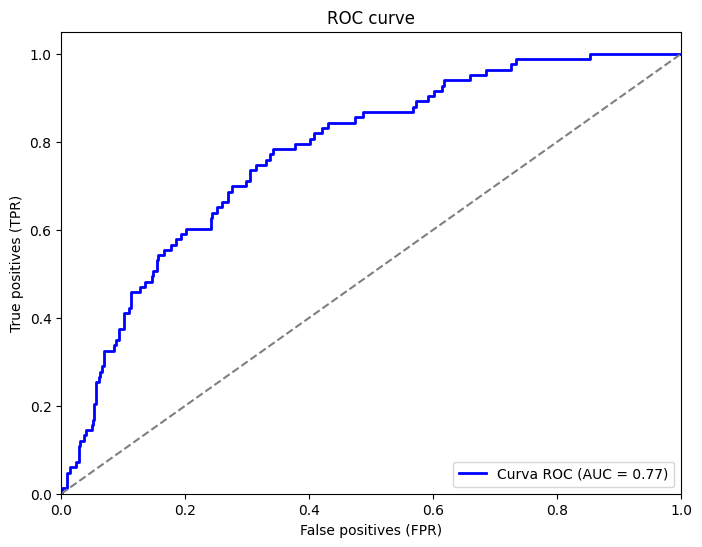

In [48]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_resampled, y_resampled)

y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm)

class_metrics(y_test=y_test,y_pred=y_pred)

plot_roc(clf,X_test,y_test)


As can be seen, with the undersampling technique the system classifies many samples as 1 erroneously, let's try the oversampling technique.